In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

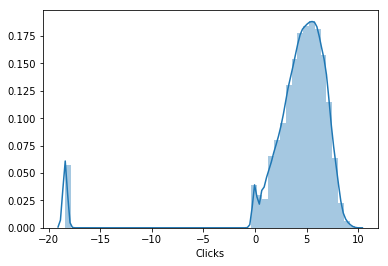

In [3]:
sns.distplot(np.log(df_train_Y['Clicks'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Clicks']:
    df_train_Y['Clicks_log'] = df_train_Y['Clicks'].apply(log)
    df_val_Y['Clicks_log'] = df_val_Y['Clicks'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Clicks_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Clicks_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 6.536027692372812e-07, 'colsample_bytree': 0.8, 'gamma': 5.146127512074319e-08, 'lambda': 1.1709349833731985e-06, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 1.9667245877238115, 'n_estimators': 142.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:4.80435	eval-rmse:4.38979                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.14902	eval-rmse:3.72491                                                                               

[2]	train-rmse:3.64809	eval-rmse:3.23621                                                                               

[3]	t

[17]	train-rmse:2.87912	eval-rmse:2.06412                                                                              

[18]	train-rmse:2.8748	eval-rmse:2.06464                                                                               

[19]	train-rmse:2.87	eval-rmse:2.07163                                                                                 

[20]	train-rmse:2.86457	eval-rmse:2.07259                                                                              

[21]	train-rmse:2.86114	eval-rmse:2.07007                                                                              

[22]	train-rmse:2.85807	eval-rmse:2.07265                                                                              

[23]	train-rmse:2.85141	eval-rmse:2.07269                                                                              

[24]	train-rmse:2.8491	eval-rmse:2.0717                                                                                

[25]	train-rmse:2.84606	eval-rms

Training with params:                                                                                                  
{'alpha': 0.024541801641930948, 'colsample_bytree': 0.65, 'gamma': 0.0029157039052920965, 'lambda': 0.0021383709424018273, 'learning_rate': 0.47500000000000003, 'max_depth': 4, 'min_child_weight': 4.658233716023028, 'n_estimators': 748.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:3.93109	eval-rmse:3.27608                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.25526	eval-rmse:2.45602                                                                               

[2]	train-rmse:3.02687	eval-rmse:2.17799                                                                       

[28]	train-rmse:2.79479	eval-rmse:2.14606                                                                              

[29]	train-rmse:2.7901	eval-rmse:2.15007                                                                               

[30]	train-rmse:2.7857	eval-rmse:2.15905                                                                               

[31]	train-rmse:2.7814	eval-rmse:2.15501                                                                               

[32]	train-rmse:2.77737	eval-rmse:2.16237                                                                              

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.87379	eval-rmse:2.08899


loss: 100259113.65476298                                                                                               
Training with params:                                                                                          

[18]	train-rmse:2.31784	eval-rmse:2.15527                                                                              

[19]	train-rmse:2.29135	eval-rmse:2.16847                                                                              

[20]	train-rmse:2.27609	eval-rmse:2.16414                                                                              

[21]	train-rmse:2.2655	eval-rmse:2.16563                                                                               

[22]	train-rmse:2.24514	eval-rmse:2.1626                                                                               

[23]	train-rmse:2.22689	eval-rmse:2.17173                                                                              

[24]	train-rmse:2.20684	eval-rmse:2.17975                                                                              

[25]	train-rmse:2.19352	eval-rmse:2.17997                                                                              

[26]	train-rmse:2.18207	eval-rms

[18]	train-rmse:2.76003	eval-rmse:2.06683                                                                              

[19]	train-rmse:2.75014	eval-rmse:2.06707                                                                              

[20]	train-rmse:2.74209	eval-rmse:2.0683                                                                               

[21]	train-rmse:2.7359	eval-rmse:2.07059                                                                               

[22]	train-rmse:2.72719	eval-rmse:2.07173                                                                              

[23]	train-rmse:2.71801	eval-rmse:2.07501                                                                              

[24]	train-rmse:2.71197	eval-rmse:2.07097                                                                              

[25]	train-rmse:2.70322	eval-rmse:2.08093                                                                              

[26]	train-rmse:2.69509	eval-rms

[42]	train-rmse:2.87885	eval-rmse:2.06659                                                                              

[43]	train-rmse:2.87626	eval-rmse:2.06676                                                                              

[44]	train-rmse:2.8745	eval-rmse:2.06655                                                                               

[45]	train-rmse:2.87215	eval-rmse:2.06628                                                                              

[46]	train-rmse:2.86984	eval-rmse:2.06724                                                                              

[47]	train-rmse:2.86789	eval-rmse:2.0682                                                                               

[48]	train-rmse:2.86622	eval-rmse:2.06806                                                                              

[49]	train-rmse:2.86458	eval-rmse:2.06786                                                                              

[50]	train-rmse:2.86296	eval-rms

[40]	train-rmse:2.83301	eval-rmse:2.06655                                                                              

[41]	train-rmse:2.83163	eval-rmse:2.06448                                                                              

[42]	train-rmse:2.829	eval-rmse:2.06402                                                                                

[43]	train-rmse:2.82667	eval-rmse:2.06538                                                                              

[44]	train-rmse:2.8251	eval-rmse:2.0639                                                                                

[45]	train-rmse:2.82274	eval-rmse:2.06381                                                                              

[46]	train-rmse:2.82073	eval-rmse:2.08219                                                                              

[47]	train-rmse:2.81871	eval-rmse:2.08196                                                                              

[48]	train-rmse:2.81649	eval-rms

loss: 100101852.29164095                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0012382760203345313, 'colsample_bytree': 0.9, 'gamma': 0.2037510467964559, 'lambda': 1.1644201430903296e-05, 'learning_rate': 0.25, 'max_depth': 7, 'min_child_weight': 2.105759568992694, 'n_estimators': 122.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:4.64713	eval-rmse:4.1794                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.94775	eval-rmse:3.41752                                                                           

[23]	train-rmse:2.44696	eval-rmse:2.12399                                                                              

[24]	train-rmse:2.42973	eval-rmse:2.1297                                                                               

[25]	train-rmse:2.42141	eval-rmse:2.13352                                                                              

Stopping. Best iteration:                                                                                              
[5]	train-rmse:2.75238	eval-rmse:2.052


loss: 99649356.97249879                                                                                                
Training with params:                                                                                                  
{'alpha': 1.3433445455891874e-08, 'colsample_bytree': 0.75, 'gamma': 0.007877044279998831, 'lambda': 0.8478859661923095, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 3.7878169897599037, 'n_estimators': 938.0

[18]	train-rmse:3.03342	eval-rmse:2.1767                                                                               

[19]	train-rmse:3.01505	eval-rmse:2.15713                                                                              

[20]	train-rmse:3.00004	eval-rmse:2.14107                                                                              

[21]	train-rmse:2.9865	eval-rmse:2.12684                                                                               

[22]	train-rmse:2.97502	eval-rmse:2.11571                                                                              

[23]	train-rmse:2.96464	eval-rmse:2.10764                                                                              

[24]	train-rmse:2.95637	eval-rmse:2.09974                                                                              

[25]	train-rmse:2.94915	eval-rmse:2.09366                                                                              

[26]	train-rmse:2.94234	eval-rms

[15]	train-rmse:2.13649	eval-rmse:2.29862                                                                              

[16]	train-rmse:2.11797	eval-rmse:2.3201                                                                               

[17]	train-rmse:2.09246	eval-rmse:2.32438                                                                              

[18]	train-rmse:2.0522	eval-rmse:2.34231                                                                               

[19]	train-rmse:2.01754	eval-rmse:2.34387                                                                              

[20]	train-rmse:1.99456	eval-rmse:2.33979                                                                              

[21]	train-rmse:1.97755	eval-rmse:2.33514                                                                              

[22]	train-rmse:1.96313	eval-rmse:2.33757                                                                              

[23]	train-rmse:1.9543	eval-rmse

[17]	train-rmse:2.77299	eval-rmse:2.0916                                                                               

[18]	train-rmse:2.7633	eval-rmse:2.08634                                                                               

[19]	train-rmse:2.75678	eval-rmse:2.08109                                                                              

[20]	train-rmse:2.74883	eval-rmse:2.07977                                                                              

[21]	train-rmse:2.74274	eval-rmse:2.07954                                                                              

[22]	train-rmse:2.73655	eval-rmse:2.083                                                                                

[23]	train-rmse:2.7327	eval-rmse:2.08238                                                                               

[24]	train-rmse:2.72528	eval-rmse:2.0789                                                                               

[25]	train-rmse:2.71897	eval-rms

[30]	train-rmse:2.48304	eval-rmse:2.09675                                                                              

[31]	train-rmse:2.47382	eval-rmse:2.0971                                                                               

[32]	train-rmse:2.46767	eval-rmse:2.10216                                                                              

[33]	train-rmse:2.45902	eval-rmse:2.1035                                                                               

[34]	train-rmse:2.4512	eval-rmse:2.10192                                                                               

[35]	train-rmse:2.44572	eval-rmse:2.10241                                                                              

[36]	train-rmse:2.43759	eval-rmse:2.10363                                                                              

[37]	train-rmse:2.4276	eval-rmse:2.10006                                                                               

[38]	train-rmse:2.42321	eval-rms

[23]	train-rmse:1.899	eval-rmse:2.23335                                                                                

[24]	train-rmse:1.87095	eval-rmse:2.24106                                                                              

[25]	train-rmse:1.84431	eval-rmse:2.25439                                                                              

[26]	train-rmse:1.82493	eval-rmse:2.25475                                                                              

[27]	train-rmse:1.80588	eval-rmse:2.25596                                                                              

[28]	train-rmse:1.78886	eval-rmse:2.25478                                                                              

[29]	train-rmse:1.77918	eval-rmse:2.25751                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.27336	eval-rmse:

[6]	train-rmse:2.53764	eval-rmse:2.27582                                                                               

[7]	train-rmse:2.44234	eval-rmse:2.22245                                                                               

[8]	train-rmse:2.37576	eval-rmse:2.19075                                                                               

[9]	train-rmse:2.30896	eval-rmse:2.18776                                                                               

[10]	train-rmse:2.26077	eval-rmse:2.21637                                                                              

[11]	train-rmse:2.22056	eval-rmse:2.20958                                                                              

[12]	train-rmse:2.18328	eval-rmse:2.20522                                                                              

[13]	train-rmse:2.15333	eval-rmse:2.20725                                                                              

[14]	train-rmse:2.12474	eval-rms

[35]	train-rmse:3.2199	eval-rmse:2.84638                                                                               

[36]	train-rmse:3.18338	eval-rmse:2.81238                                                                              

[37]	train-rmse:3.14865	eval-rmse:2.78063                                                                              

[38]	train-rmse:3.11478	eval-rmse:2.75167                                                                              

[39]	train-rmse:3.08117	eval-rmse:2.72301                                                                              

[40]	train-rmse:3.04998	eval-rmse:2.69545                                                                              

[41]	train-rmse:3.01901	eval-rmse:2.66811                                                                              

[42]	train-rmse:2.98907	eval-rmse:2.64254                                                                              

[43]	train-rmse:2.96109	eval-rms

{'alpha': 5.546779798643018e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.0020833465933822897, 'lambda': 0.0334701141680225, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 0.32913940157014343, 'n_estimators': 572.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:4.70318	eval-rmse:4.27271                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.9921	eval-rmse:3.55991                                                                                

[2]	train-rmse:3.47102	eval-rmse:3.068                                                                                 

[3]	train-rmse:3.10565	eval-rmse:2.71941                                                        

[25]	train-rmse:3.85837	eval-rmse:3.25051                                                                              

[26]	train-rmse:3.8166	eval-rmse:3.20163                                                                               

[27]	train-rmse:3.77623	eval-rmse:3.1552                                                                               

[28]	train-rmse:3.73752	eval-rmse:3.10969                                                                              

[29]	train-rmse:3.70002	eval-rmse:3.06591                                                                              

[30]	train-rmse:3.66399	eval-rmse:3.02422                                                                              

[31]	train-rmse:3.62992	eval-rmse:2.98449                                                                              

[32]	train-rmse:3.5965	eval-rmse:2.94567                                                                               

[33]	train-rmse:3.56463	eval-rms

[92]	train-rmse:2.84965	eval-rmse:2.11256                                                                              

[93]	train-rmse:2.84647	eval-rmse:2.10991                                                                              

[94]	train-rmse:2.84319	eval-rmse:2.1076                                                                               

[95]	train-rmse:2.8397	eval-rmse:2.10548                                                                               

[96]	train-rmse:2.83675	eval-rmse:2.10337                                                                              

[97]	train-rmse:2.83349	eval-rmse:2.10177                                                                              

[98]	train-rmse:2.83041	eval-rmse:2.10003                                                                              

[99]	train-rmse:2.82727	eval-rmse:2.09773                                                                              

loss: 101498451.2153529         

[14]	train-rmse:2.19118	eval-rmse:2.12101                                                                              

[15]	train-rmse:2.17106	eval-rmse:2.1199                                                                               

[16]	train-rmse:2.15465	eval-rmse:2.12057                                                                              

[17]	train-rmse:2.12386	eval-rmse:2.12059                                                                              

[18]	train-rmse:2.09625	eval-rmse:2.12849                                                                              

[19]	train-rmse:2.08122	eval-rmse:2.12814                                                                              

[20]	train-rmse:2.05037	eval-rmse:2.13267                                                                              

[21]	train-rmse:2.02928	eval-rmse:2.12695                                                                              

[22]	train-rmse:2.0153	eval-rmse

[43]	train-rmse:2.09179	eval-rmse:2.17152                                                                              

[44]	train-rmse:2.08254	eval-rmse:2.17285                                                                              

[45]	train-rmse:2.07566	eval-rmse:2.17411                                                                              

[46]	train-rmse:2.06775	eval-rmse:2.17963                                                                              

[47]	train-rmse:2.057	eval-rmse:2.19471                                                                                

[48]	train-rmse:2.04881	eval-rmse:2.1948                                                                               

[49]	train-rmse:2.03867	eval-rmse:2.19591                                                                              

[50]	train-rmse:2.0322	eval-rmse:2.19531                                                                               

[51]	train-rmse:2.02628	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.89152	eval-rmse:3.27553                                                                               

[2]	train-rmse:3.46245	eval-rmse:2.76672                                                                               

[3]	train-rmse:3.19925	eval-rmse:2.45952                                                                               

[4]	train-rmse:3.04194	eval-rmse:2.28311                                                                               

[5]	train-rmse:2.94767	eval-rmse:2.18588                                                                               

[6]	train-rmse:2.88712	eval-rmse:2.13111                                                                               

[7]	train-rmse:2.85186	eval-rms

[26]	train-rmse:2.46713	eval-rmse:2.17934                                                                              

[27]	train-rmse:2.4588	eval-rmse:2.19825                                                                               

[28]	train-rmse:2.44715	eval-rmse:2.1941                                                                               

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.70541	eval-rmse:2.12344


loss: 102196631.16841638                                                                                               
Training with params:                                                                                                  
{'alpha': 6.227200712358499e-07, 'colsample_bytree': 0.65, 'gamma': 0.000979212173309051, 'lambda': 0.0007155390579841684, 'learning_rate': 0.225, 'max_depth': 8, 'min_child_weight': 0.14489606126823149, 'n_estimators': 620.0, 'nthrea

[17]	train-rmse:2.03243	eval-rmse:2.20398                                                                              

[18]	train-rmse:2.01074	eval-rmse:2.21436                                                                              

[19]	train-rmse:1.97669	eval-rmse:2.22274                                                                              

[20]	train-rmse:1.95152	eval-rmse:2.23916                                                                              

[21]	train-rmse:1.93867	eval-rmse:2.24017                                                                              

[22]	train-rmse:1.9242	eval-rmse:2.24485                                                                               

[23]	train-rmse:1.90998	eval-rmse:2.24645                                                                              

[24]	train-rmse:1.8835	eval-rmse:2.25507                                                                               

[25]	train-rmse:1.86924	eval-rms

[0]	train-rmse:4.0866	eval-rmse:3.46773                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.37702	eval-rmse:2.61518                                                                               

[2]	train-rmse:3.09222	eval-rmse:2.2725                                                                                

[3]	train-rmse:2.96563	eval-rmse:2.14755                                                                               

[4]	train-rmse:2.91204	eval-rmse:2.10027                                                                               

[5]	train-rmse:2.88597	eval-rmse:2.08659                                                                               

[6]	train-rmse:2.86679	eval-rms

loss: 98737353.66898267                                                                                                
Training with params:                                                                                                  
{'alpha': 4.117403257697192e-08, 'colsample_bytree': 0.8, 'gamma': 0.37613594570297154, 'lambda': 5.790151943032663e-05, 'learning_rate': 0.375, 'max_depth': 9, 'min_child_weight': 0.5403388168226948, 'n_estimators': 455.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:4.10303	eval-rmse:3.66925                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.25302	eval-rmse:2.87224                                                                               

[2]	tra

loss: 100303887.23786                                                                                                  
Training with params:                                                                                                  
{'alpha': 2.9084082667559236e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.9284790255347003, 'lambda': 5.6210798102349066e-05, 'learning_rate': 0.42500000000000004, 'max_depth': 9, 'min_child_weight': 0.10119383834892777, 'n_estimators': 580.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:3.91613	eval-rmse:3.47236                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.05699	eval-rmse:2.64596                                          

[26]	train-rmse:2.4446	eval-rmse:2.16857                                                                               

[27]	train-rmse:2.43636	eval-rmse:2.16769                                                                              

[28]	train-rmse:2.42535	eval-rmse:2.17306                                                                              

[29]	train-rmse:2.41194	eval-rmse:2.16598                                                                              

[30]	train-rmse:2.39708	eval-rmse:2.16845                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.66056	eval-rmse:2.10411


loss: 99523926.60120705                                                                                                
Training with params:                                                                                          

[16]	train-rmse:2.78201	eval-rmse:2.08393                                                                              

[17]	train-rmse:2.77865	eval-rmse:2.08214                                                                              

[18]	train-rmse:2.77551	eval-rmse:2.08111                                                                              

[19]	train-rmse:2.76908	eval-rmse:2.0805                                                                               

[20]	train-rmse:2.76345	eval-rmse:2.08087                                                                              

[21]	train-rmse:2.7572	eval-rmse:2.078                                                                                 

[22]	train-rmse:2.75236	eval-rmse:2.10266                                                                              

[23]	train-rmse:2.74304	eval-rmse:2.10143                                                                              

[24]	train-rmse:2.73536	eval-rms

[12]	train-rmse:2.56991	eval-rmse:2.13619                                                                              

[13]	train-rmse:2.549	eval-rmse:2.13408                                                                                

[14]	train-rmse:2.53159	eval-rmse:2.13911                                                                              

[15]	train-rmse:2.51307	eval-rmse:2.13642                                                                              

[16]	train-rmse:2.49435	eval-rmse:2.13838                                                                              

[17]	train-rmse:2.47097	eval-rmse:2.14012                                                                              

[18]	train-rmse:2.45914	eval-rmse:2.14268                                                                              

[19]	train-rmse:2.44476	eval-rmse:2.14481                                                                              

[20]	train-rmse:2.43457	eval-rms

[38]	train-rmse:2.55156	eval-rmse:2.20079                                                                              

[39]	train-rmse:2.53705	eval-rmse:2.19534                                                                              

[40]	train-rmse:2.52145	eval-rmse:2.18562                                                                              

[41]	train-rmse:2.50738	eval-rmse:2.18246                                                                              

[42]	train-rmse:2.49254	eval-rmse:2.17583                                                                              

[43]	train-rmse:2.4805	eval-rmse:2.17395                                                                               

[44]	train-rmse:2.46769	eval-rmse:2.17009                                                                              

[45]	train-rmse:2.45393	eval-rmse:2.16328                                                                              

[46]	train-rmse:2.44156	eval-rms

[13]	train-rmse:2.90094	eval-rmse:2.06312                                                                              

[14]	train-rmse:2.89677	eval-rmse:2.0643                                                                               

[15]	train-rmse:2.88941	eval-rmse:2.06538                                                                              

[16]	train-rmse:2.88692	eval-rmse:2.06434                                                                              

[17]	train-rmse:2.88164	eval-rmse:2.06351                                                                              

[18]	train-rmse:2.87825	eval-rmse:2.11684                                                                              

[19]	train-rmse:2.87229	eval-rmse:2.11746                                                                              

[20]	train-rmse:2.86513	eval-rmse:2.11777                                                                              

[21]	train-rmse:2.86076	eval-rms

[4]	train-rmse:2.95019	eval-rmse:2.18321                                                                               

[5]	train-rmse:2.88746	eval-rmse:2.12976                                                                               

[6]	train-rmse:2.84628	eval-rmse:2.10949                                                                               

[7]	train-rmse:2.82133	eval-rmse:2.09309                                                                               

[8]	train-rmse:2.80114	eval-rmse:2.15395                                                                               

[9]	train-rmse:2.78488	eval-rmse:2.15223                                                                               

[10]	train-rmse:2.76973	eval-rmse:2.14729                                                                              

[11]	train-rmse:2.75458	eval-rmse:2.1445                                                                               

[12]	train-rmse:2.73991	eval-rms

[35]	train-rmse:2.75164	eval-rmse:2.09851                                                                              

[36]	train-rmse:2.74751	eval-rmse:2.09722                                                                              

[37]	train-rmse:2.74473	eval-rmse:2.09367                                                                              

[38]	train-rmse:2.74028	eval-rmse:2.09423                                                                              

[39]	train-rmse:2.73639	eval-rmse:2.09352                                                                              

[40]	train-rmse:2.73154	eval-rmse:2.09233                                                                              

Stopping. Best iteration:                                                                                              
[20]	train-rmse:2.82486	eval-rmse:2.05968


loss: 100214739.97302839                                                                                      

[20]	train-rmse:1.71314	eval-rmse:2.31282                                                                              

[21]	train-rmse:1.69517	eval-rmse:2.29991                                                                              

[22]	train-rmse:1.66933	eval-rmse:2.30419                                                                              

[23]	train-rmse:1.65452	eval-rmse:2.30842                                                                              

[24]	train-rmse:1.63357	eval-rmse:2.30806                                                                              

[25]	train-rmse:1.62372	eval-rmse:2.30496                                                                              

[26]	train-rmse:1.59565	eval-rmse:2.29966                                                                              

[27]	train-rmse:1.5872	eval-rmse:2.30309                                                                               

Stopping. Best iteration:       

[13]	train-rmse:2.53812	eval-rmse:2.12855                                                                              

[14]	train-rmse:2.51747	eval-rmse:2.12754                                                                              

[15]	train-rmse:2.50414	eval-rmse:2.12784                                                                              

[16]	train-rmse:2.49281	eval-rmse:2.13317                                                                              

[17]	train-rmse:2.47942	eval-rmse:2.13033                                                                              

[18]	train-rmse:2.46301	eval-rmse:2.14019                                                                              

[19]	train-rmse:2.44231	eval-rmse:2.1374                                                                               

[20]	train-rmse:2.43051	eval-rmse:2.13918                                                                              

[21]	train-rmse:2.42257	eval-rms

[15]	train-rmse:2.07771	eval-rmse:2.3379                                                                               

[16]	train-rmse:2.06065	eval-rmse:2.33608                                                                              

[17]	train-rmse:2.01437	eval-rmse:2.33449                                                                              

[18]	train-rmse:1.98655	eval-rmse:2.34055                                                                              

[19]	train-rmse:1.97306	eval-rmse:2.33952                                                                              

[20]	train-rmse:1.93534	eval-rmse:2.34671                                                                              

[21]	train-rmse:1.91179	eval-rmse:2.36067                                                                              

[22]	train-rmse:1.88894	eval-rmse:2.36054                                                                              

[23]	train-rmse:1.87815	eval-rms

[12]	train-rmse:2.42668	eval-rmse:2.12423                                                                              

[13]	train-rmse:2.40389	eval-rmse:2.12422                                                                              

[14]	train-rmse:2.38718	eval-rmse:2.12707                                                                              

[15]	train-rmse:2.35513	eval-rmse:2.12693                                                                              

[16]	train-rmse:2.34842	eval-rmse:2.12805                                                                              

[17]	train-rmse:2.32331	eval-rmse:2.13472                                                                              

[18]	train-rmse:2.30471	eval-rmse:2.13274                                                                              

[19]	train-rmse:2.2893	eval-rmse:2.13611                                                                               

[20]	train-rmse:2.26962	eval-rms

[7]	train-rmse:2.77432	eval-rmse:2.10478                                                                               

[8]	train-rmse:2.75886	eval-rmse:2.10161                                                                               

[9]	train-rmse:2.73575	eval-rmse:2.11861                                                                               

[10]	train-rmse:2.72389	eval-rmse:2.11462                                                                              

[11]	train-rmse:2.71155	eval-rmse:2.1205                                                                               

[12]	train-rmse:2.70674	eval-rmse:2.13305                                                                              

[13]	train-rmse:2.69769	eval-rmse:2.14116                                                                              

[14]	train-rmse:2.68646	eval-rmse:2.13877                                                                              

[15]	train-rmse:2.68064	eval-rms

[5]	train-rmse:2.74199	eval-rmse:2.08129                                                                               

[6]	train-rmse:2.71611	eval-rmse:2.07915                                                                               

[7]	train-rmse:2.69148	eval-rmse:2.09669                                                                               

[8]	train-rmse:2.66202	eval-rmse:2.1116                                                                                

[9]	train-rmse:2.6406	eval-rmse:2.11428                                                                                

[10]	train-rmse:2.61849	eval-rmse:2.12444                                                                              

[11]	train-rmse:2.60969	eval-rmse:2.12748                                                                              

[12]	train-rmse:2.5992	eval-rmse:2.12987                                                                               

[13]	train-rmse:2.58902	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.87311	eval-rmse:3.41335                                                                               

[2]	train-rmse:3.36593	eval-rmse:2.90639                                                                               

[3]	train-rmse:3.03348	eval-rmse:2.57363                                                                               

[4]	train-rmse:2.80949	eval-rmse:2.37403                                                                               

[5]	train-rmse:2.65232	eval-rmse:2.25602                                                                               

[6]	train-rmse:2.53707	eval-rmse:2.19306                                                                               

[7]	train-rmse:2.46289	eval-rms

[28]	train-rmse:2.81376	eval-rmse:2.10331                                                                              

[29]	train-rmse:2.81011	eval-rmse:2.10514                                                                              

[30]	train-rmse:2.80709	eval-rmse:2.10691                                                                              

[31]	train-rmse:2.80461	eval-rmse:2.10637                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:2.89962	eval-rmse:2.06233


loss: 100297945.40070076                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0007574182546549579, 'colsample_bytree': 0.9, 'gamma': 3.723071642319951e-05, 'lambda': 1.7001155532

[21]	train-rmse:1.6892	eval-rmse:2.36102                                                                               

[22]	train-rmse:1.67233	eval-rmse:2.36002                                                                              

[23]	train-rmse:1.66252	eval-rmse:2.35994                                                                              

[24]	train-rmse:1.63687	eval-rmse:2.35728                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.3918	eval-rmse:2.25887


loss: 98940839.79112233                                                                                                
Training with params:                                                                                                  
{'alpha': 1.904259380999207e-05, 'colsample_bytree': 0.9, 'gamma': 1.4308460234989978e-05, 'lambda': 3.99584143694

[20]	train-rmse:1.77856	eval-rmse:2.26988                                                                              

[21]	train-rmse:1.76451	eval-rmse:2.27167                                                                              

[22]	train-rmse:1.72735	eval-rmse:2.27654                                                                              

[23]	train-rmse:1.70647	eval-rmse:2.27644                                                                              

[24]	train-rmse:1.66431	eval-rmse:2.28542                                                                              

[25]	train-rmse:1.62006	eval-rmse:2.28676                                                                              

[26]	train-rmse:1.5804	eval-rmse:2.29016                                                                               

[27]	train-rmse:1.55516	eval-rmse:2.30686                                                                              

[28]	train-rmse:1.54572	eval-rms

[14]	train-rmse:2.02077	eval-rmse:2.31434                                                                              

[15]	train-rmse:1.99146	eval-rmse:2.31477                                                                              

[16]	train-rmse:1.96261	eval-rmse:2.31805                                                                              

[17]	train-rmse:1.91874	eval-rmse:2.32308                                                                              

[18]	train-rmse:1.90399	eval-rmse:2.32274                                                                              

[19]	train-rmse:1.88734	eval-rmse:2.32759                                                                              

[20]	train-rmse:1.85037	eval-rmse:2.32973                                                                              

[21]	train-rmse:1.82347	eval-rmse:2.33375                                                                              

[22]	train-rmse:1.79318	eval-rms

[10]	train-rmse:2.01366	eval-rmse:2.30173                                                                              

[11]	train-rmse:1.9566	eval-rmse:2.30349                                                                               

[12]	train-rmse:1.90886	eval-rmse:2.31147                                                                              

[13]	train-rmse:1.88514	eval-rmse:2.32227                                                                              

[14]	train-rmse:1.84775	eval-rmse:2.32245                                                                              

[15]	train-rmse:1.79219	eval-rmse:2.33385                                                                              

[16]	train-rmse:1.74513	eval-rmse:2.32698                                                                              

[17]	train-rmse:1.71709	eval-rmse:2.32832                                                                              

[18]	train-rmse:1.67222	eval-rms

[8]	train-rmse:2.53551	eval-rmse:2.09709                                                                               

[9]	train-rmse:2.51007	eval-rmse:2.09328                                                                               

[10]	train-rmse:2.48671	eval-rmse:2.09758                                                                              

[11]	train-rmse:2.45101	eval-rmse:2.10998                                                                              

[12]	train-rmse:2.42919	eval-rmse:2.12316                                                                              

[13]	train-rmse:2.41289	eval-rmse:2.12155                                                                              

[14]	train-rmse:2.40531	eval-rmse:2.14411                                                                              

[15]	train-rmse:2.37904	eval-rmse:2.14102                                                                              

[16]	train-rmse:2.35905	eval-rms

[1]	train-rmse:4.16381	eval-rmse:3.56496                                                                               

[2]	train-rmse:3.73285	eval-rmse:3.05356                                                                               

[3]	train-rmse:3.44203	eval-rmse:2.70044                                                                               

[4]	train-rmse:3.2474	eval-rmse:2.46842                                                                                

[5]	train-rmse:3.12154	eval-rmse:2.31584                                                                               

[6]	train-rmse:3.03641	eval-rmse:2.21837                                                                               

[7]	train-rmse:2.98071	eval-rmse:2.15941                                                                               

[8]	train-rmse:2.93937	eval-rmse:2.11872                                                                               

[9]	train-rmse:2.91277	eval-rmse

{'alpha': 0.0027382992783562166, 'colsample_bytree': 0.8, 'gamma': 0.0027913542660920024, 'lambda': 0.00018060189098121482, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 0.30659562986135985, 'n_estimators': 211.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:4.38929	eval-rmse:3.96976                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.57084	eval-rmse:3.15422                                                                               

[2]	train-rmse:3.05119	eval-rmse:2.70393                                                                               

[3]	train-rmse:2.73403	eval-rmse:2.43957                                                     

[25]	train-rmse:1.75853	eval-rmse:2.25737                                                                              

[26]	train-rmse:1.73945	eval-rmse:2.25549                                                                              

[27]	train-rmse:1.71099	eval-rmse:2.25911                                                                              

[28]	train-rmse:1.70629	eval-rmse:2.25609                                                                              

[29]	train-rmse:1.69512	eval-rmse:2.26486                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.2011	eval-rmse:2.189


loss: 98699285.89474411                                                                                                
Training with params:                                                                                              

[16]	train-rmse:2.50723	eval-rmse:2.18542                                                                              

[17]	train-rmse:2.47308	eval-rmse:2.17197                                                                              

[18]	train-rmse:2.44674	eval-rmse:2.18214                                                                              

[19]	train-rmse:2.42247	eval-rmse:2.17208                                                                              

[20]	train-rmse:2.39846	eval-rmse:2.16519                                                                              

[21]	train-rmse:2.37923	eval-rmse:2.16588                                                                              

[22]	train-rmse:2.36102	eval-rmse:2.16808                                                                              

[23]	train-rmse:2.3409	eval-rmse:2.16519                                                                               

[24]	train-rmse:2.3267	eval-rmse

[32]	train-rmse:1.6348	eval-rmse:2.2398                                                                                

[33]	train-rmse:1.62724	eval-rmse:2.24041                                                                              

[34]	train-rmse:1.61371	eval-rmse:2.24529                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:2.05539	eval-rmse:2.18269


loss: 98498642.07583687                                                                                                
Training with params:                                                                                                  
{'alpha': 7.913520027083505e-06, 'colsample_bytree': 0.8, 'gamma': 0.06707369316771498, 'lambda': 3.0239125926179697e-05, 'learning_rate': 0.4, 'max_depth': 7, 'min_child_weight': 0.15609457473078908, 'n_estimators': 480.0, 'nthread'

[24]	train-rmse:2.62342	eval-rmse:2.07436                                                                              

[25]	train-rmse:2.61557	eval-rmse:2.07359                                                                              

[26]	train-rmse:2.60309	eval-rmse:2.07404                                                                              

[27]	train-rmse:2.59544	eval-rmse:2.07972                                                                              

[28]	train-rmse:2.58846	eval-rmse:2.07005                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.78989	eval-rmse:2.06136


loss: 99765881.0368108                                                                                                 
Training with params:                                                                                           

[10]	train-rmse:2.63046	eval-rmse:2.10405                                                                              

[11]	train-rmse:2.61228	eval-rmse:2.10134                                                                              

[12]	train-rmse:2.58363	eval-rmse:2.10666                                                                              

[13]	train-rmse:2.5732	eval-rmse:2.10979                                                                               

[14]	train-rmse:2.56896	eval-rmse:2.10788                                                                              

[15]	train-rmse:2.55802	eval-rmse:2.11211                                                                              

[16]	train-rmse:2.54273	eval-rmse:2.10867                                                                              

[17]	train-rmse:2.52252	eval-rmse:2.1075                                                                               

[18]	train-rmse:2.51024	eval-rms

[5]	train-rmse:2.21051	eval-rmse:2.20345                                                                               

[6]	train-rmse:2.13087	eval-rmse:2.2141                                                                                

[7]	train-rmse:2.08064	eval-rmse:2.21408                                                                               

[8]	train-rmse:2.04221	eval-rmse:2.21327                                                                               

[9]	train-rmse:2.00886	eval-rmse:2.22026                                                                               

[10]	train-rmse:1.95755	eval-rmse:2.23468                                                                              

[11]	train-rmse:1.92884	eval-rmse:2.23744                                                                              

[12]	train-rmse:1.90985	eval-rmse:2.24377                                                                              

[13]	train-rmse:1.88365	eval-rms

[5]	train-rmse:2.52699	eval-rmse:2.20676                                                                               

[6]	train-rmse:2.49452	eval-rmse:2.21481                                                                               

[7]	train-rmse:2.45831	eval-rmse:2.21743                                                                               

[8]	train-rmse:2.42103	eval-rmse:2.29796                                                                               

[9]	train-rmse:2.39251	eval-rmse:2.29137                                                                               

[10]	train-rmse:2.36382	eval-rmse:2.28959                                                                              

[11]	train-rmse:2.34031	eval-rmse:2.32436                                                                              

[12]	train-rmse:2.30266	eval-rmse:2.33427                                                                              

[13]	train-rmse:2.27901	eval-rms

[2]	train-rmse:3.24643	eval-rmse:2.66992                                                                               

[3]	train-rmse:2.98264	eval-rmse:2.40064                                                                               

[4]	train-rmse:2.82532	eval-rmse:2.25144                                                                               

[5]	train-rmse:2.73053	eval-rmse:2.23978                                                                               

[6]	train-rmse:2.6655	eval-rmse:2.2084                                                                                 

[7]	train-rmse:2.6126	eval-rmse:2.19141                                                                                

[8]	train-rmse:2.57094	eval-rmse:2.19535                                                                               

[9]	train-rmse:2.54778	eval-rmse:2.18736                                                                               

[10]	train-rmse:2.52441	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.40493	eval-rmse:2.70702                                                                               

[2]	train-rmse:3.07759	eval-rmse:2.3141                                                                                

[3]	train-rmse:2.93036	eval-rmse:2.16407                                                                               

[4]	train-rmse:2.86397	eval-rmse:2.10302                                                                               

[5]	train-rmse:2.82375	eval-rmse:2.08791                                                                               

[6]	train-rmse:2.80077	eval-rmse:2.08532                                                                               

[7]	train-rmse:2.78006	eval-rms

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.85694	eval-rmse:2.12525


loss: 100002894.01934278                                                                                               
Training with params:                                                                                                  
{'alpha': 0.16137245972520528, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.8618752951406116e-07, 'lambda': 0.0011527666784069668, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3.2809682593191956, 'n_estimators': 171.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:4.80809	eval-rmse:4.38712                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.

[14]	train-rmse:2.765	eval-rmse:2.1154                                                                                 

[15]	train-rmse:2.74612	eval-rmse:2.10342                                                                              

[16]	train-rmse:2.72681	eval-rmse:2.09583                                                                              

[17]	train-rmse:2.70896	eval-rmse:2.08553                                                                              

[18]	train-rmse:2.69386	eval-rmse:2.09281                                                                              

[19]	train-rmse:2.68102	eval-rmse:2.08431                                                                              

[20]	train-rmse:2.66869	eval-rmse:2.08449                                                                              

[21]	train-rmse:2.65997	eval-rmse:2.08539                                                                              

[22]	train-rmse:2.64766	eval-rms

[1]	train-rmse:3.65836	eval-rmse:2.93071                                                                               

[2]	train-rmse:3.29742	eval-rmse:2.48483                                                                               

[3]	train-rmse:3.1155	eval-rmse:2.26177                                                                                

[4]	train-rmse:3.02491	eval-rmse:2.16433                                                                               

[5]	train-rmse:2.9738	eval-rmse:2.11945                                                                                

[6]	train-rmse:2.9458	eval-rmse:2.10429                                                                                

[7]	train-rmse:2.92892	eval-rmse:2.09089                                                                               

[8]	train-rmse:2.91592	eval-rmse:2.08088                                                                               

[9]	train-rmse:2.90369	eval-rmse

loss: 98801492.58921428                                                                                                
Training with params:                                                                                                  
{'alpha': 0.004416485195996654, 'colsample_bytree': 0.9, 'gamma': 0.002134079775403542, 'lambda': 0.5582357371058235, 'learning_rate': 0.325, 'max_depth': 8, 'min_child_weight': 2.3387235682221625, 'n_estimators': 409.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:4.33533	eval-rmse:3.86424                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.53599	eval-rmse:3.02463                                                                            

[24]	train-rmse:1.81941	eval-rmse:2.20283                                                                              

[25]	train-rmse:1.78982	eval-rmse:2.2057                                                                               

[26]	train-rmse:1.74562	eval-rmse:2.21143                                                                              

[27]	train-rmse:1.72724	eval-rmse:2.2159                                                                               

[28]	train-rmse:1.71473	eval-rmse:2.22301                                                                              

[29]	train-rmse:1.69895	eval-rmse:2.22362                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.22996	eval-rmse:2.15905


loss: 98712837.32049784                                                                                        

[17]	train-rmse:2.66212	eval-rmse:2.18163                                                                              

[18]	train-rmse:2.65417	eval-rmse:2.17468                                                                              

[19]	train-rmse:2.64396	eval-rmse:2.18213                                                                              

[20]	train-rmse:2.63082	eval-rmse:2.1902                                                                               

[21]	train-rmse:2.62598	eval-rmse:2.18962                                                                              

[22]	train-rmse:2.62075	eval-rmse:2.1913                                                                               

[23]	train-rmse:2.61473	eval-rmse:2.18949                                                                              

[24]	train-rmse:2.60832	eval-rmse:2.19218                                                                              

[25]	train-rmse:2.59909	eval-rms

[9]	train-rmse:2.81241	eval-rmse:2.09943                                                                               

[10]	train-rmse:2.80602	eval-rmse:2.1214                                                                               

[11]	train-rmse:2.80086	eval-rmse:2.11788                                                                              

[12]	train-rmse:2.78629	eval-rmse:2.13308                                                                              

[13]	train-rmse:2.78138	eval-rmse:2.13583                                                                              

[14]	train-rmse:2.76815	eval-rmse:2.13776                                                                              

[15]	train-rmse:2.7624	eval-rmse:2.13439                                                                               

[16]	train-rmse:2.75065	eval-rmse:2.13478                                                                              

[17]	train-rmse:2.73944	eval-rms

[42]	train-rmse:2.57158	eval-rmse:2.09348                                                                              

[43]	train-rmse:2.56547	eval-rmse:2.101                                                                                

[44]	train-rmse:2.55854	eval-rmse:2.10929                                                                              

[45]	train-rmse:2.55524	eval-rmse:2.10885                                                                              

[46]	train-rmse:2.54969	eval-rmse:2.11272                                                                              

[47]	train-rmse:2.54162	eval-rmse:2.11485                                                                              

Stopping. Best iteration:                                                                                              
[27]	train-rmse:2.66145	eval-rmse:2.08535


loss: 100004322.4881316                                                                                       

[21]	train-rmse:3.09905	eval-rmse:2.25326                                                                              

[22]	train-rmse:3.07726	eval-rmse:2.22842                                                                              

[23]	train-rmse:3.05833	eval-rmse:2.2087                                                                               

[24]	train-rmse:3.04171	eval-rmse:2.1891                                                                               

[25]	train-rmse:3.02551	eval-rmse:2.17255                                                                              

[26]	train-rmse:3.01255	eval-rmse:2.16039                                                                              

[27]	train-rmse:2.99978	eval-rmse:2.14825                                                                              

[28]	train-rmse:2.98967	eval-rmse:2.13741                                                                              

[29]	train-rmse:2.98062	eval-rms

[5]	train-rmse:2.28941	eval-rmse:2.15298                                                                               

[6]	train-rmse:2.20856	eval-rmse:2.17639                                                                               

[7]	train-rmse:2.16588	eval-rmse:2.18762                                                                               

[8]	train-rmse:2.14374	eval-rmse:2.20103                                                                               

[9]	train-rmse:2.11369	eval-rmse:2.20021                                                                               

[10]	train-rmse:2.04607	eval-rmse:2.21055                                                                              

[11]	train-rmse:2.0304	eval-rmse:2.20795                                                                               

[12]	train-rmse:1.9847	eval-rmse:2.21795                                                                               

[13]	train-rmse:1.95926	eval-rms

[1]	train-rmse:3.33463	eval-rmse:2.92323                                                                               

[2]	train-rmse:2.8401	eval-rmse:2.50834                                                                                

[3]	train-rmse:2.56253	eval-rmse:2.31934                                                                               

[4]	train-rmse:2.4156	eval-rmse:2.23138                                                                                

[5]	train-rmse:2.30072	eval-rmse:2.22835                                                                               

[6]	train-rmse:2.23593	eval-rmse:2.20903                                                                               

[7]	train-rmse:2.1849	eval-rmse:2.1986                                                                                 

[8]	train-rmse:2.14179	eval-rmse:2.21803                                                                               

[9]	train-rmse:2.08632	eval-rmse

Stopping. Best iteration:                                                                                              
[12]	train-rmse:2.50947	eval-rmse:2.1339


loss: 99332876.6962606                                                                                                 
Training with params:                                                                                                  
{'alpha': 2.4312224669036723e-07, 'colsample_bytree': 0.9, 'gamma': 0.0029822558219882362, 'lambda': 2.8122184448390544e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 5, 'min_child_weight': 0.20808535920036517, 'n_estimators': 153.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:4.96533	eval-rmse:4.49898                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rou

[18]	train-rmse:1.85492	eval-rmse:2.32438                                                                              

[19]	train-rmse:1.83615	eval-rmse:2.32714                                                                              

[20]	train-rmse:1.83055	eval-rmse:2.32724                                                                              

[21]	train-rmse:1.80299	eval-rmse:2.33301                                                                              

[22]	train-rmse:1.78507	eval-rmse:2.34114                                                                              

[23]	train-rmse:1.76987	eval-rmse:2.34199                                                                              

[24]	train-rmse:1.75259	eval-rmse:2.37173                                                                              

[25]	train-rmse:1.73163	eval-rmse:2.37836                                                                              

[26]	train-rmse:1.71755	eval-rms

[8]	train-rmse:2.83357	eval-rmse:2.08108                                                                               

[9]	train-rmse:2.81854	eval-rmse:2.10011                                                                               

[10]	train-rmse:2.80871	eval-rmse:2.10016                                                                              

[11]	train-rmse:2.79848	eval-rmse:2.1018                                                                               

[12]	train-rmse:2.79395	eval-rmse:2.10184                                                                              

[13]	train-rmse:2.78601	eval-rmse:2.10158                                                                              

[14]	train-rmse:2.78143	eval-rmse:2.09865                                                                              

[15]	train-rmse:2.77266	eval-rmse:2.09523                                                                              

[16]	train-rmse:2.76125	eval-rms

[7]	train-rmse:2.97303	eval-rmse:2.10362                                                                               

[8]	train-rmse:2.94996	eval-rmse:2.08847                                                                               

[9]	train-rmse:2.93118	eval-rmse:2.08536                                                                               

[10]	train-rmse:2.92081	eval-rmse:2.07723                                                                              

[11]	train-rmse:2.90935	eval-rmse:2.08044                                                                              

[12]	train-rmse:2.90224	eval-rmse:2.07697                                                                              

[13]	train-rmse:2.89395	eval-rmse:2.08512                                                                              

[14]	train-rmse:2.8891	eval-rmse:2.08408                                                                               

[15]	train-rmse:2.88373	eval-rms

[2]	train-rmse:3.00315	eval-rmse:2.53371                                                                               

[3]	train-rmse:2.76875	eval-rmse:2.3437                                                                                

[4]	train-rmse:2.64557	eval-rmse:2.26153                                                                               

[5]	train-rmse:2.56604	eval-rmse:2.27433                                                                               

[6]	train-rmse:2.50023	eval-rmse:2.27838                                                                               

[7]	train-rmse:2.46114	eval-rmse:2.28189                                                                               

[8]	train-rmse:2.42793	eval-rmse:2.28634                                                                               

[9]	train-rmse:2.38581	eval-rmse:2.30636                                                                               

[10]	train-rmse:2.34995	eval-rms

[2]	train-rmse:3.08578	eval-rmse:2.32634                                                                               

[3]	train-rmse:2.9451	eval-rmse:2.16611                                                                                

[4]	train-rmse:2.87297	eval-rmse:2.11111                                                                               

[5]	train-rmse:2.83358	eval-rmse:2.08484                                                                               

[6]	train-rmse:2.80811	eval-rmse:2.08746                                                                               

[7]	train-rmse:2.78905	eval-rmse:2.08916                                                                               

[8]	train-rmse:2.77545	eval-rmse:2.09261                                                                               

[9]	train-rmse:2.76482	eval-rmse:2.10256                                                                               

[10]	train-rmse:2.74884	eval-rms

[3]	train-rmse:2.42655	eval-rmse:2.24666                                                                               

[4]	train-rmse:2.34258	eval-rmse:2.26709                                                                               

[5]	train-rmse:2.26455	eval-rmse:2.28296                                                                               

[6]	train-rmse:2.19002	eval-rmse:2.29435                                                                               

[7]	train-rmse:2.1506	eval-rmse:2.28706                                                                                

[8]	train-rmse:2.12597	eval-rmse:2.29735                                                                               

[9]	train-rmse:2.08883	eval-rmse:2.32299                                                                               

[10]	train-rmse:2.06679	eval-rmse:2.31861                                                                              

[11]	train-rmse:2.04591	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.11077	eval-rmse:3.56216                                                                               

[2]	train-rmse:3.65927	eval-rmse:3.05366                                                                               

[3]	train-rmse:3.35077	eval-rmse:2.6981                                                                                

[4]	train-rmse:3.14139	eval-rmse:2.46584                                                                               

[5]	train-rmse:3.00061	eval-rmse:2.32945                                                                               

[6]	train-rmse:2.90171	eval-rmse:2.23556                                                                               

[7]	train-rmse:2.83231	eval-rmse:2.17348                                                                               

[8]	train-rmse:2.78389	eval-rmse

[26]	train-rmse:2.0168	eval-rmse:2.1495                                                                                

[27]	train-rmse:2.00495	eval-rmse:2.14893                                                                              

[28]	train-rmse:1.9897	eval-rmse:2.14868                                                                               

[29]	train-rmse:1.98177	eval-rmse:2.14826                                                                              

[30]	train-rmse:1.95826	eval-rmse:2.15437                                                                              

[31]	train-rmse:1.94209	eval-rmse:2.1597                                                                               

[32]	train-rmse:1.93287	eval-rmse:2.15857                                                                              

[33]	train-rmse:1.9198	eval-rmse:2.16003                                                                               

[34]	train-rmse:1.90217	eval-rms

[4]	train-rmse:2.73483	eval-rmse:2.39138                                                                               

[5]	train-rmse:2.5686	eval-rmse:2.2697                                                                                 

[6]	train-rmse:2.45281	eval-rmse:2.19595                                                                               

[7]	train-rmse:2.36741	eval-rmse:2.17448                                                                               

[8]	train-rmse:2.29921	eval-rmse:2.17559                                                                               

[9]	train-rmse:2.24087	eval-rmse:2.17137                                                                               

[10]	train-rmse:2.20204	eval-rmse:2.16743                                                                              

[11]	train-rmse:2.1686	eval-rmse:2.19093                                                                               

[12]	train-rmse:2.13863	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.05685	eval-rmse:2.40477                                                                               

[2]	train-rmse:2.80838	eval-rmse:2.16645                                                                               

[3]	train-rmse:2.71199	eval-rmse:2.11465                                                                               

[4]	train-rmse:2.66055	eval-rmse:2.09726                                                                               

[5]	train-rmse:2.62661	eval-rmse:2.19876                                                                               

[6]	train-rmse:2.58426	eval-rmse:2.20376                                                                               

[7]	train-rmse:2.54104	eval-rmse:2.21503                                                                               

[8]	train-rmse:2.50834	eval-rmse

[2]	train-rmse:2.74809	eval-rmse:2.46795                                                                               

[3]	train-rmse:2.54282	eval-rmse:2.34627                                                                               

[4]	train-rmse:2.41612	eval-rmse:2.30116                                                                               

[5]	train-rmse:2.34579	eval-rmse:2.31599                                                                               

[6]	train-rmse:2.26374	eval-rmse:2.32653                                                                               

[7]	train-rmse:2.21099	eval-rmse:2.34086                                                                               

[8]	train-rmse:2.15973	eval-rmse:2.33424                                                                               

[9]	train-rmse:2.11077	eval-rmse:2.35515                                                                               

[10]	train-rmse:2.08253	eval-rms

[1]	train-rmse:3.37697	eval-rmse:2.61517                                                                               

[2]	train-rmse:3.08781	eval-rmse:2.2699                                                                                

[3]	train-rmse:2.96326	eval-rmse:2.14005                                                                               

[4]	train-rmse:2.90713	eval-rmse:2.09493                                                                               

[5]	train-rmse:2.88006	eval-rmse:2.08052                                                                               

[6]	train-rmse:2.85927	eval-rmse:2.07937                                                                               

[7]	train-rmse:2.84022	eval-rmse:2.07268                                                                               

[8]	train-rmse:2.82779	eval-rmse:2.06583                                                                               

[9]	train-rmse:2.81633	eval-rmse

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.29414	eval-rmse:2.6217                                                                                

[2]	train-rmse:2.98362	eval-rmse:2.30152                                                                               

[3]	train-rmse:2.84026	eval-rmse:2.17296                                                                               

[4]	train-rmse:2.77122	eval-rmse:2.14637                                                                               

[5]	train-rmse:2.73812	eval-rmse:2.12628                                                                               

[6]	train-rmse:2.71223	eval-rmse:2.12163                                                                               

[7]	train-rmse:2.67805	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.65657	eval-rmse:2.92392                                                                               

[2]	train-rmse:3.29966	eval-rmse:2.4796                                                                                

[3]	train-rmse:3.12118	eval-rmse:2.25949                                                                               

[4]	train-rmse:3.03101	eval-rmse:2.15917                                                                               

[5]	train-rmse:2.97901	eval-rmse:2.11411                                                                               

[6]	train-rmse:2.95169	eval-rmse:2.09349                                                                               

[7]	train-rmse:2.93471	eval-rmse:2.09461                                                                               

[8]	train-rmse:2.91861	eval-rmse

[19]	train-rmse:1.89526	eval-rmse:2.19836                                                                              

[20]	train-rmse:1.88121	eval-rmse:2.23772                                                                              

[21]	train-rmse:1.84821	eval-rmse:2.2394                                                                               

[22]	train-rmse:1.83216	eval-rmse:2.24105                                                                              

[23]	train-rmse:1.8126	eval-rmse:2.24971                                                                               

[24]	train-rmse:1.80098	eval-rmse:2.25444                                                                              

[25]	train-rmse:1.7688	eval-rmse:2.2567                                                                                

[26]	train-rmse:1.73186	eval-rmse:2.26769                                                                              

[27]	train-rmse:1.70863	eval-rms

[10]	train-rmse:1.96876	eval-rmse:2.242                                                                                

[11]	train-rmse:1.93199	eval-rmse:2.24159                                                                              

[12]	train-rmse:1.90736	eval-rmse:2.24519                                                                              

[13]	train-rmse:1.87185	eval-rmse:2.25503                                                                              

[14]	train-rmse:1.85175	eval-rmse:2.2615                                                                               

[15]	train-rmse:1.79727	eval-rmse:2.26536                                                                              

[16]	train-rmse:1.77059	eval-rmse:2.28948                                                                              

[17]	train-rmse:1.74312	eval-rmse:2.29205                                                                              

[18]	train-rmse:1.70572	eval-rms

[9]	train-rmse:2.06214	eval-rmse:2.28898                                                                               

[10]	train-rmse:2.02961	eval-rmse:2.28357                                                                              

[11]	train-rmse:1.97812	eval-rmse:2.29144                                                                              

[12]	train-rmse:1.95867	eval-rmse:2.30143                                                                              

[13]	train-rmse:1.93009	eval-rmse:2.30548                                                                              

[14]	train-rmse:1.88351	eval-rmse:2.3075                                                                               

[15]	train-rmse:1.85362	eval-rmse:2.31196                                                                              

[16]	train-rmse:1.83072	eval-rmse:2.33113                                                                              

[17]	train-rmse:1.8161	eval-rmse

[12]	train-rmse:1.92474	eval-rmse:2.29009                                                                              

[13]	train-rmse:1.86217	eval-rmse:2.29835                                                                              

[14]	train-rmse:1.83471	eval-rmse:2.28992                                                                              

[15]	train-rmse:1.81042	eval-rmse:2.29268                                                                              

[16]	train-rmse:1.78327	eval-rmse:2.31112                                                                              

[17]	train-rmse:1.74976	eval-rmse:2.30794                                                                              

[18]	train-rmse:1.73578	eval-rmse:2.30801                                                                              

[19]	train-rmse:1.68068	eval-rmse:2.32662                                                                              

[20]	train-rmse:1.66115	eval-rms

[15]	train-rmse:1.93559	eval-rmse:2.25873                                                                              

[16]	train-rmse:1.90331	eval-rmse:2.26037                                                                              

[17]	train-rmse:1.88758	eval-rmse:2.2606                                                                               

[18]	train-rmse:1.86596	eval-rmse:2.26007                                                                              

[19]	train-rmse:1.80497	eval-rmse:2.2841                                                                               

[20]	train-rmse:1.77513	eval-rmse:2.28819                                                                              

[21]	train-rmse:1.75568	eval-rmse:2.28961                                                                              

[22]	train-rmse:1.7252	eval-rmse:2.29037                                                                               

[23]	train-rmse:1.70313	eval-rms

[14]	train-rmse:1.88866	eval-rmse:2.25971                                                                              

[15]	train-rmse:1.84149	eval-rmse:2.27083                                                                              

[16]	train-rmse:1.81524	eval-rmse:2.27519                                                                              

[17]	train-rmse:1.78253	eval-rmse:2.27677                                                                              

[18]	train-rmse:1.74961	eval-rmse:2.28469                                                                              

[19]	train-rmse:1.71893	eval-rmse:2.29583                                                                              

[20]	train-rmse:1.69624	eval-rmse:2.31114                                                                              

[21]	train-rmse:1.67121	eval-rmse:2.31493                                                                              

[22]	train-rmse:1.63527	eval-rms

[13]	train-rmse:1.95389	eval-rmse:2.24521                                                                              

[14]	train-rmse:1.9067	eval-rmse:2.26065                                                                               

[15]	train-rmse:1.86033	eval-rmse:2.26567                                                                              

[16]	train-rmse:1.82808	eval-rmse:2.27343                                                                              

[17]	train-rmse:1.79037	eval-rmse:2.27658                                                                              

[18]	train-rmse:1.76831	eval-rmse:2.28079                                                                              

[19]	train-rmse:1.74485	eval-rmse:2.28054                                                                              

[20]	train-rmse:1.71772	eval-rmse:2.28247                                                                              

[21]	train-rmse:1.70073	eval-rms

[14]	train-rmse:2.72194	eval-rmse:2.14462                                                                              

[15]	train-rmse:2.70909	eval-rmse:2.1429                                                                               

[16]	train-rmse:2.69828	eval-rmse:2.14194                                                                              

[17]	train-rmse:2.68502	eval-rmse:2.14469                                                                              

[18]	train-rmse:2.67737	eval-rmse:2.14386                                                                              

[19]	train-rmse:2.66616	eval-rmse:2.14574                                                                              

[20]	train-rmse:2.65925	eval-rmse:2.14929                                                                              

[21]	train-rmse:2.65343	eval-rmse:2.15089                                                                              

[22]	train-rmse:2.64484	eval-rms

[5]	train-rmse:2.77721	eval-rmse:2.1309                                                                                

[6]	train-rmse:2.73312	eval-rmse:2.1188                                                                                

[7]	train-rmse:2.70804	eval-rmse:2.12906                                                                               

[8]	train-rmse:2.68278	eval-rmse:2.12987                                                                               

[9]	train-rmse:2.6624	eval-rmse:2.13513                                                                                

[10]	train-rmse:2.64924	eval-rmse:2.13889                                                                              

[11]	train-rmse:2.63672	eval-rmse:2.13657                                                                              

[12]	train-rmse:2.61667	eval-rmse:2.13865                                                                              

[13]	train-rmse:2.59201	eval-rms

[4]	train-rmse:2.36948	eval-rmse:2.21047                                                                               

[5]	train-rmse:2.29331	eval-rmse:2.20597                                                                               

[6]	train-rmse:2.20606	eval-rmse:2.21597                                                                               

[7]	train-rmse:2.15323	eval-rmse:2.21514                                                                               

[8]	train-rmse:2.09866	eval-rmse:2.21546                                                                               

[9]	train-rmse:2.06712	eval-rmse:2.21628                                                                               

[10]	train-rmse:2.04231	eval-rmse:2.22558                                                                              

[11]	train-rmse:1.99286	eval-rmse:2.23325                                                                              

[12]	train-rmse:1.97106	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:2.985	eval-rmse:2.57624                                                                                 

[2]	train-rmse:2.6275	eval-rmse:2.30907                                                                                

[3]	train-rmse:2.44605	eval-rmse:2.20666                                                                               

[4]	train-rmse:2.35066	eval-rmse:2.1808                                                                                

[5]	train-rmse:2.29352	eval-rmse:2.17968                                                                               

[6]	train-rmse:2.20739	eval-rmse:2.23069                                                                               

[7]	train-rmse:2.14884	eval-rmse:2.28248                                                                               

[8]	train-rmse:2.11491	eval-rmse

[1]	train-rmse:2.93064	eval-rmse:2.48547                                                                               

[2]	train-rmse:2.59869	eval-rmse:2.3                                                                                   

[3]	train-rmse:2.43131	eval-rmse:2.23302                                                                               

[4]	train-rmse:2.34339	eval-rmse:2.22115                                                                               

[5]	train-rmse:2.28072	eval-rmse:2.23059                                                                               

[6]	train-rmse:2.22236	eval-rmse:2.239                                                                                 

[7]	train-rmse:2.19039	eval-rmse:2.25511                                                                               

[8]	train-rmse:2.14439	eval-rmse:2.26985                                                                               

[9]	train-rmse:2.10629	eval-rmse

[2]	train-rmse:3.08857	eval-rmse:2.31487                                                                               

[3]	train-rmse:2.93959	eval-rmse:2.1703                                                                                

[4]	train-rmse:2.87143	eval-rmse:2.11367                                                                               

[5]	train-rmse:2.83759	eval-rmse:2.09665                                                                               

[6]	train-rmse:2.80707	eval-rmse:2.09937                                                                               

[7]	train-rmse:2.78335	eval-rmse:2.09913                                                                               

[8]	train-rmse:2.76378	eval-rmse:2.08937                                                                               

[9]	train-rmse:2.74818	eval-rmse:2.08925                                                                               

[10]	train-rmse:2.73652	eval-rms

[0]	train-rmse:4.00665	eval-rmse:3.37051                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.31587	eval-rmse:2.528                                                                                 

[2]	train-rmse:3.05357	eval-rmse:2.21905                                                                               

[3]	train-rmse:2.94928	eval-rmse:2.12203                                                                               

[4]	train-rmse:2.90241	eval-rmse:2.08931                                                                               

[5]	train-rmse:2.87907	eval-rmse:2.07769                                                                               

[6]	train-rmse:2.86259	eval-rms

[21]	train-rmse:2.46312	eval-rmse:2.19715                                                                              

[22]	train-rmse:2.45241	eval-rmse:2.21302                                                                              

[23]	train-rmse:2.44078	eval-rmse:2.21337                                                                              

[24]	train-rmse:2.43105	eval-rmse:2.21632                                                                              

[25]	train-rmse:2.42038	eval-rmse:2.21586                                                                              

[26]	train-rmse:2.40804	eval-rmse:2.24399                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.71733	eval-rmse:2.06789


loss: 99376454.11367618                                                                                        

[17]	train-rmse:2.85729	eval-rmse:2.08894                                                                              

[18]	train-rmse:2.85342	eval-rmse:2.09053                                                                              

[19]	train-rmse:2.84857	eval-rmse:2.09332                                                                              

[20]	train-rmse:2.84129	eval-rmse:2.09333                                                                              

[21]	train-rmse:2.83919	eval-rmse:2.09334                                                                              

[22]	train-rmse:2.83399	eval-rmse:2.09265                                                                              

[23]	train-rmse:2.82978	eval-rmse:2.09389                                                                              

[24]	train-rmse:2.82403	eval-rmse:2.08744                                                                              

[25]	train-rmse:2.82294	eval-rms

[28]	train-rmse:1.69531	eval-rmse:2.18843                                                                              

[29]	train-rmse:1.67374	eval-rmse:2.18557                                                                              

[30]	train-rmse:1.65197	eval-rmse:2.18903                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:2.16236	eval-rmse:2.12828


loss: 98727132.5917982                                                                                                 
Training with params:                                                                                                  
{'alpha': 0.002354025533199385, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.003934862357708474, 'lambda': 0.011938576040710244, 'learning_rate': 0.47500000000000003, 'max_depth': 8, 'min_child_weight': 0.25127841393511635, 'n_

[25]	train-rmse:1.70587	eval-rmse:2.26976                                                                              

Stopping. Best iteration:                                                                                              
[5]	train-rmse:2.33326	eval-rmse:2.18411


loss: 98468992.47193538                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0010959360760983716, 'colsample_bytree': 0.65, 'gamma': 0.014465855331611837, 'lambda': 3.434486940228952, 'learning_rate': 0.4, 'max_depth': 7, 'min_child_weight': 7.398428402028987, 'n_estimators': 483.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.1066	eval-rmse:3.55605                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.        

[21]	train-rmse:1.90963	eval-rmse:2.29331                                                                              

[22]	train-rmse:1.88653	eval-rmse:2.29446                                                                              

[23]	train-rmse:1.87489	eval-rmse:2.29215                                                                              

[24]	train-rmse:1.84129	eval-rmse:2.29614                                                                              

[25]	train-rmse:1.82228	eval-rmse:2.29624                                                                              

[26]	train-rmse:1.80534	eval-rmse:2.30945                                                                              

[27]	train-rmse:1.77818	eval-rmse:2.31807                                                                              

[28]	train-rmse:1.75537	eval-rmse:2.3304                                                                               

Stopping. Best iteration:       

[16]	train-rmse:1.95853	eval-rmse:2.24941                                                                              

[17]	train-rmse:1.92697	eval-rmse:2.25835                                                                              

[18]	train-rmse:1.90315	eval-rmse:2.29884                                                                              

[19]	train-rmse:1.87962	eval-rmse:2.29853                                                                              

[20]	train-rmse:1.87	eval-rmse:2.29888                                                                                 

[21]	train-rmse:1.85222	eval-rmse:2.29341                                                                              

[22]	train-rmse:1.83291	eval-rmse:2.28737                                                                              

[23]	train-rmse:1.82392	eval-rmse:2.2847                                                                               

[24]	train-rmse:1.81133	eval-rms

[13]	train-rmse:3.72587	eval-rmse:3.13261                                                                              

[14]	train-rmse:3.64798	eval-rmse:3.04563                                                                              

[15]	train-rmse:3.57557	eval-rmse:2.96342                                                                              

[16]	train-rmse:3.50901	eval-rmse:2.88718                                                                              

[17]	train-rmse:3.44646	eval-rmse:2.8174                                                                               

[18]	train-rmse:3.38828	eval-rmse:2.75188                                                                              

[19]	train-rmse:3.33533	eval-rmse:2.69318                                                                              

[20]	train-rmse:3.28619	eval-rmse:2.63822                                                                              

[21]	train-rmse:3.24124	eval-rms

[80]	train-rmse:2.6103	eval-rmse:2.08553                                                                               

[81]	train-rmse:2.60756	eval-rmse:2.08562                                                                              

[82]	train-rmse:2.60545	eval-rmse:2.08498                                                                              

[83]	train-rmse:2.60314	eval-rmse:2.08436                                                                              

[84]	train-rmse:2.60059	eval-rmse:2.08458                                                                              

[85]	train-rmse:2.59712	eval-rmse:2.08363                                                                              

[86]	train-rmse:2.59473	eval-rmse:2.08391                                                                              

[87]	train-rmse:2.59251	eval-rmse:2.08422                                                                              

[88]	train-rmse:2.58859	eval-rms

[5]	train-rmse:2.96574	eval-rmse:2.09932                                                                               

[6]	train-rmse:2.94653	eval-rmse:2.08301                                                                               

[7]	train-rmse:2.9304	eval-rmse:2.0754                                                                                 

[8]	train-rmse:2.91783	eval-rmse:2.07654                                                                               

[9]	train-rmse:2.90958	eval-rmse:2.07633                                                                               

[10]	train-rmse:2.89961	eval-rmse:2.07203                                                                              

[11]	train-rmse:2.89585	eval-rmse:2.07165                                                                              

[12]	train-rmse:2.88638	eval-rmse:2.07104                                                                              

[13]	train-rmse:2.87844	eval-rms


loss: 98684025.09066026                                                                                                
Training with params:                                                                                                  
{'alpha': 1.8260225756515064e-07, 'colsample_bytree': 0.75, 'gamma': 0.002461995274458993, 'lambda': 8.818485222424861e-06, 'learning_rate': 0.35000000000000003, 'max_depth': 8, 'min_child_weight': 1.0237990926077203, 'n_estimators': 520.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:4.24012	eval-rmse:3.7538                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.4328	eval-rmse:2.92089                                                        

{'alpha': 1.0426139885387893e-05, 'colsample_bytree': 0.65, 'gamma': 0.018194565517968667, 'lambda': 0.0008747660747796421, 'learning_rate': 0.47500000000000003, 'max_depth': 7, 'min_child_weight': 0.29248263487338566, 'n_estimators': 755.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:3.83856	eval-rmse:3.27176                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.11591	eval-rmse:2.4793                                                                                

[2]	train-rmse:2.83878	eval-rmse:2.22055                                                                               

[3]	train-rmse:2.70771	eval-rmse:2.16671                                                                    

{'alpha': 6.191421958715707e-08, 'colsample_bytree': 0.8, 'gamma': 0.005125307236687967, 'lambda': 0.07739175412712847, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 0.3971083727570738, 'n_estimators': 447.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.49333	eval-rmse:3.96716                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.77447	eval-rmse:3.1486                                                                                

[2]	train-rmse:3.35363	eval-rmse:2.65368                                                                               

[3]	train-rmse:3.11515	eval-rmse:2.37367                                                                         

[22]	train-rmse:1.84123	eval-rmse:2.27758                                                                              

[23]	train-rmse:1.82449	eval-rmse:2.27683                                                                              

[24]	train-rmse:1.80107	eval-rmse:2.27804                                                                              

[25]	train-rmse:1.78846	eval-rmse:2.28506                                                                              

[26]	train-rmse:1.75993	eval-rmse:2.27668                                                                              

[27]	train-rmse:1.73677	eval-rmse:2.27297                                                                              

[28]	train-rmse:1.73134	eval-rmse:2.2733                                                                               

[29]	train-rmse:1.71104	eval-rmse:2.27767                                                                              

Stopping. Best iteration:       

[17]	train-rmse:2.53914	eval-rmse:2.12771                                                                              

[18]	train-rmse:2.52699	eval-rmse:2.12869                                                                              

[19]	train-rmse:2.51287	eval-rmse:2.11805                                                                              

[20]	train-rmse:2.49419	eval-rmse:2.12555                                                                              

[21]	train-rmse:2.4877	eval-rmse:2.12546                                                                               

[22]	train-rmse:2.47369	eval-rmse:2.12377                                                                              

[23]	train-rmse:2.46078	eval-rmse:2.12871                                                                              

[24]	train-rmse:2.44262	eval-rmse:2.14748                                                                              

[25]	train-rmse:2.4356	eval-rmse

[16]	train-rmse:1.93106	eval-rmse:2.21387                                                                              

[17]	train-rmse:1.90874	eval-rmse:2.22348                                                                              

[18]	train-rmse:1.89178	eval-rmse:2.22647                                                                              

[19]	train-rmse:1.87615	eval-rmse:2.22528                                                                              

[20]	train-rmse:1.85705	eval-rmse:2.22723                                                                              

[21]	train-rmse:1.82152	eval-rmse:2.23157                                                                              

[22]	train-rmse:1.80677	eval-rmse:2.23137                                                                              

[23]	train-rmse:1.76236	eval-rmse:2.23854                                                                              

[24]	train-rmse:1.74824	eval-rms

[15]	train-rmse:2.90251	eval-rmse:2.07537                                                                              

[16]	train-rmse:2.89471	eval-rmse:2.07653                                                                              

[17]	train-rmse:2.88924	eval-rmse:2.0744                                                                               

[18]	train-rmse:2.8842	eval-rmse:2.07515                                                                               

[19]	train-rmse:2.87865	eval-rmse:2.07646                                                                              

[20]	train-rmse:2.87185	eval-rmse:2.06894                                                                              

[21]	train-rmse:2.86695	eval-rmse:2.0688                                                                               

[22]	train-rmse:2.86337	eval-rmse:2.06919                                                                              

[23]	train-rmse:2.86207	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.22714	eval-rmse:3.71531                                                                               

[2]	train-rmse:3.76596	eval-rmse:3.2212                                                                                

[3]	train-rmse:3.43248	eval-rmse:2.85554                                                                               

[4]	train-rmse:3.19528	eval-rmse:2.6006                                                                                

[5]	train-rmse:3.02273	eval-rmse:2.438                                                                                 

[6]	train-rmse:2.89475	eval-rmse:2.31312                                                                               

[7]	train-rmse:2.804	eval-rmse:

[25]	train-rmse:1.67892	eval-rmse:2.3743                                                                               

[26]	train-rmse:1.65569	eval-rmse:2.39032                                                                              

[27]	train-rmse:1.63367	eval-rmse:2.40224                                                                              

[28]	train-rmse:1.62017	eval-rmse:2.40699                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.15909	eval-rmse:2.2098


loss: 98962792.67753832                                                                                                
Training with params:                                                                                                  
{'alpha': 2.2107762683688604e-08, 'colsample_bytree': 0.9500000000000001, 'gamma': 2.5614513367508323e-05, 'lambda

[23]	train-rmse:1.70658	eval-rmse:2.55739                                                                              

[24]	train-rmse:1.69778	eval-rmse:2.56585                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.34378	eval-rmse:2.27731


loss: 102936439.86070217                                                                                               
Training with params:                                                                                                  
{'alpha': 0.010975828736974372, 'colsample_bytree': 0.9, 'gamma': 0.008255305599405368, 'lambda': 2.247224727706369e-05, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 0.7682355702065329, 'n_estimators': 250.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.60396	eval-rmse:4.07372                                               

[19]	train-rmse:2.53141	eval-rmse:2.17138                                                                              

[20]	train-rmse:2.52239	eval-rmse:2.228                                                                                

[21]	train-rmse:2.51442	eval-rmse:2.20594                                                                              

[22]	train-rmse:2.50232	eval-rmse:2.21237                                                                              

[23]	train-rmse:2.49311	eval-rmse:2.21111                                                                              

[24]	train-rmse:2.47718	eval-rmse:2.20781                                                                              

[25]	train-rmse:2.46251	eval-rmse:2.20896                                                                              

[26]	train-rmse:2.45016	eval-rmse:2.21651                                                                              

[27]	train-rmse:2.44201	eval-rms

[19]	train-rmse:1.9451	eval-rmse:2.24611                                                                               

[20]	train-rmse:1.9293	eval-rmse:2.24703                                                                               

[21]	train-rmse:1.91886	eval-rmse:2.24953                                                                              

[22]	train-rmse:1.90678	eval-rmse:2.25305                                                                              

[23]	train-rmse:1.87971	eval-rmse:2.25746                                                                              

[24]	train-rmse:1.85281	eval-rmse:2.26706                                                                              

[25]	train-rmse:1.83152	eval-rmse:2.26929                                                                              

[26]	train-rmse:1.81578	eval-rmse:2.26781                                                                              

[27]	train-rmse:1.77767	eval-rms

[8]	train-rmse:2.16395	eval-rmse:2.29139                                                                               

[9]	train-rmse:2.13137	eval-rmse:2.29883                                                                               

[10]	train-rmse:2.09659	eval-rmse:2.31076                                                                              

[11]	train-rmse:2.07668	eval-rmse:2.31973                                                                              

[12]	train-rmse:2.05595	eval-rmse:2.33274                                                                              

[13]	train-rmse:2.03351	eval-rmse:2.3363                                                                               

[14]	train-rmse:2.00316	eval-rmse:2.3485                                                                               

[15]	train-rmse:1.97692	eval-rmse:2.35311                                                                              

[16]	train-rmse:1.95087	eval-rms

[10]	train-rmse:2.02374	eval-rmse:2.30544                                                                              

[11]	train-rmse:2.00328	eval-rmse:2.30586                                                                              

[12]	train-rmse:1.96776	eval-rmse:2.30149                                                                              

[13]	train-rmse:1.91947	eval-rmse:2.30252                                                                              

[14]	train-rmse:1.89175	eval-rmse:2.33393                                                                              

[15]	train-rmse:1.87146	eval-rmse:2.33742                                                                              

[16]	train-rmse:1.84653	eval-rmse:2.34823                                                                              

[17]	train-rmse:1.81587	eval-rmse:2.34334                                                                              

[18]	train-rmse:1.76528	eval-rms

[13]	train-rmse:2.70726	eval-rmse:2.10821                                                                              

[14]	train-rmse:2.70071	eval-rmse:2.10639                                                                              

[15]	train-rmse:2.69436	eval-rmse:2.10639                                                                              

[16]	train-rmse:2.68485	eval-rmse:2.10941                                                                              

[17]	train-rmse:2.67289	eval-rmse:2.10642                                                                              

[18]	train-rmse:2.66615	eval-rmse:2.18639                                                                              

[19]	train-rmse:2.65419	eval-rmse:2.18842                                                                              

[20]	train-rmse:2.64915	eval-rmse:2.19853                                                                              

[21]	train-rmse:2.64191	eval-rms

[0]	train-rmse:4.51465	eval-rmse:3.9677                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.81197	eval-rmse:3.13861                                                                               

[2]	train-rmse:3.40319	eval-rmse:2.64835                                                                               

[3]	train-rmse:3.17068	eval-rmse:2.36742                                                                               

[4]	train-rmse:3.0421	eval-rmse:2.22337                                                                                

[5]	train-rmse:2.97157	eval-rmse:2.14454                                                                               

[6]	train-rmse:2.92801	eval-rms

[26]	train-rmse:2.38555	eval-rmse:2.27256                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:2.72436	eval-rmse:2.09888


loss: 99792014.15888998                                                                                                
Training with params:                                                                                                  
{'alpha': 1.4722852788891375e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0013259811831128228, 'lambda': 0.0001512666584003937, 'learning_rate': 0.375, 'max_depth': 9, 'min_child_weight': 0.6048567693589106, 'n_estimators': 566.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.10609	eval-rmse:3.6748                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for 

[25]	train-rmse:2.10176	eval-rmse:2.18703                                                                              

[26]	train-rmse:2.08524	eval-rmse:2.18856                                                                              

[27]	train-rmse:2.06531	eval-rmse:2.18501                                                                              

[28]	train-rmse:2.0408	eval-rmse:2.18736                                                                               

[29]	train-rmse:2.0323	eval-rmse:2.18842                                                                               

[30]	train-rmse:2.01318	eval-rmse:2.18715                                                                              

[31]	train-rmse:1.99847	eval-rmse:2.18333                                                                              

[32]	train-rmse:1.98227	eval-rmse:2.19895                                                                              

[33]	train-rmse:1.97293	eval-rms

[9]	train-rmse:2.1474	eval-rmse:2.24622                                                                                

[10]	train-rmse:2.12092	eval-rmse:2.25084                                                                              

[11]	train-rmse:2.07952	eval-rmse:2.2577                                                                               

[12]	train-rmse:2.04569	eval-rmse:2.27252                                                                              

[13]	train-rmse:2.02272	eval-rmse:2.26332                                                                              

[14]	train-rmse:1.98211	eval-rmse:2.27828                                                                              

[15]	train-rmse:1.96038	eval-rmse:2.28375                                                                              

[16]	train-rmse:1.93208	eval-rmse:2.28289                                                                              

[17]	train-rmse:1.90518	eval-rms

[9]	train-rmse:2.10069	eval-rmse:2.33751                                                                               

[10]	train-rmse:2.0632	eval-rmse:2.33702                                                                               

[11]	train-rmse:2.00911	eval-rmse:2.346                                                                                

[12]	train-rmse:1.97283	eval-rmse:2.36568                                                                              

[13]	train-rmse:1.93482	eval-rmse:2.36334                                                                              

[14]	train-rmse:1.91385	eval-rmse:2.36391                                                                              

[15]	train-rmse:1.87678	eval-rmse:2.38468                                                                              

[16]	train-rmse:1.84169	eval-rmse:2.3844                                                                               

[17]	train-rmse:1.82403	eval-rms

[8]	train-rmse:2.75946	eval-rmse:2.11694                                                                               

[9]	train-rmse:2.74022	eval-rmse:2.11825                                                                               

[10]	train-rmse:2.73073	eval-rmse:2.11643                                                                              

[11]	train-rmse:2.71588	eval-rmse:2.1341                                                                               

[12]	train-rmse:2.69905	eval-rmse:2.12888                                                                              

[13]	train-rmse:2.688	eval-rmse:2.13304                                                                                

[14]	train-rmse:2.67234	eval-rmse:2.13531                                                                              

[15]	train-rmse:2.66179	eval-rmse:2.14479                                                                              

[16]	train-rmse:2.65691	eval-rms

[8]	train-rmse:2.87052	eval-rmse:2.06525                                                                               

[9]	train-rmse:2.85152	eval-rmse:2.06229                                                                               

[10]	train-rmse:2.84005	eval-rmse:2.06397                                                                              

[11]	train-rmse:2.82766	eval-rmse:2.06737                                                                              

[12]	train-rmse:2.81962	eval-rmse:2.06592                                                                              

[13]	train-rmse:2.80944	eval-rmse:2.08013                                                                              

[14]	train-rmse:2.8016	eval-rmse:2.07849                                                                               

[15]	train-rmse:2.79474	eval-rmse:2.07692                                                                              

[16]	train-rmse:2.7896	eval-rmse

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.98316	eval-rmse:3.41043                                                                               

[2]	train-rmse:3.52908	eval-rmse:2.89844                                                                               

[3]	train-rmse:3.23567	eval-rmse:2.56268                                                                               

[4]	train-rmse:3.05006	eval-rmse:2.3569                                                                                

[5]	train-rmse:2.93539	eval-rmse:2.23843                                                                               

[6]	train-rmse:2.85411	eval-rmse:2.1633                                                                                

[7]	train-rmse:2.79873	eval-rmse:2.1219                                                                                

[8]	train-rmse:2.75791	eval-rmse

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.19215	eval-rmse:2.16621


loss: 98550538.30750549                                                                                                
Training with params:                                                                                                  
{'alpha': 1.0139405566290101e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.05575056162728722, 'lambda': 4.968125991706821e-06, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 0.297680182963338, 'n_estimators': 156.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:4.19773	eval-rmse:3.57632                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                

[20]	train-rmse:1.84372	eval-rmse:2.35389                                                                              

[21]	train-rmse:1.82451	eval-rmse:2.35965                                                                              

[22]	train-rmse:1.80708	eval-rmse:2.36382                                                                              

[23]	train-rmse:1.7988	eval-rmse:2.35921                                                                               

[24]	train-rmse:1.77775	eval-rmse:2.36909                                                                              

[25]	train-rmse:1.73954	eval-rmse:2.37171                                                                              

Stopping. Best iteration:                                                                                              
[5]	train-rmse:2.33391	eval-rmse:2.20153


loss: 98934782.627153                                                                                          

[20]	train-rmse:1.69853	eval-rmse:2.41972                                                                              

[21]	train-rmse:1.66797	eval-rmse:2.42578                                                                              

[22]	train-rmse:1.64394	eval-rmse:2.42439                                                                              

[23]	train-rmse:1.63298	eval-rmse:2.42232                                                                              

[24]	train-rmse:1.61033	eval-rmse:2.42321                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.36103	eval-rmse:2.23876


loss: 98930807.15860161                                                                                                
Training with params:                                                                                           

[9]	train-rmse:2.73829	eval-rmse:2.11912                                                                               

[10]	train-rmse:2.72237	eval-rmse:2.12149                                                                              

[11]	train-rmse:2.71268	eval-rmse:2.1235                                                                               

[12]	train-rmse:2.70742	eval-rmse:2.12631                                                                              

[13]	train-rmse:2.69457	eval-rmse:2.13591                                                                              

[14]	train-rmse:2.68334	eval-rmse:2.13195                                                                              

[15]	train-rmse:2.67305	eval-rmse:2.14239                                                                              

[16]	train-rmse:2.66303	eval-rmse:2.13957                                                                              

[17]	train-rmse:2.65662	eval-rms

[5]	train-rmse:2.89616	eval-rmse:2.09586                                                                               

[6]	train-rmse:2.87601	eval-rmse:2.09273                                                                               

[7]	train-rmse:2.86003	eval-rmse:2.09051                                                                               

[8]	train-rmse:2.84206	eval-rmse:2.11309                                                                               

[9]	train-rmse:2.83102	eval-rmse:2.11007                                                                               

[10]	train-rmse:2.82323	eval-rmse:2.12625                                                                              

[11]	train-rmse:2.81467	eval-rmse:2.13015                                                                              

[12]	train-rmse:2.79976	eval-rmse:2.12821                                                                              

[13]	train-rmse:2.79384	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.63973	eval-rmse:3.01863                                                                               

[2]	train-rmse:3.22628	eval-rmse:2.55079                                                                               

[3]	train-rmse:2.99917	eval-rmse:2.3092                                                                                

[4]	train-rmse:2.87607	eval-rmse:2.1854                                                                                

[5]	train-rmse:2.80446	eval-rmse:2.13523                                                                               

[6]	train-rmse:2.75362	eval-rmse:2.11915                                                                               

[7]	train-rmse:2.72004	eval-rmse:2.10163                                                                               

[8]	train-rmse:2.6993	eval-rmse:

[0]	train-rmse:4.28091	eval-rmse:3.67583                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.57313	eval-rmse:2.82844                                                                               

[2]	train-rmse:3.2353	eval-rmse:2.40522                                                                                

[3]	train-rmse:3.07533	eval-rmse:2.21842                                                                               

[4]	train-rmse:3.00267	eval-rmse:2.14336                                                                               

[5]	train-rmse:2.96615	eval-rmse:2.10475                                                                               

[6]	train-rmse:2.943	eval-rmse:

[27]	train-rmse:1.72086	eval-rmse:2.31287                                                                              

[28]	train-rmse:1.69859	eval-rmse:2.314                                                                                

[29]	train-rmse:1.67891	eval-rmse:2.31633                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:2.18926	eval-rmse:2.23653


loss: 98480103.61781524                                                                                                
Training with params:                                                                                                  
{'alpha': 1.650840657559285e-07, 'colsample_bytree': 0.65, 'gamma': 0.00010374724414521894, 'lambda': 0.003746669564512596, 'learning_rate': 0.45, 'max_depth': 8, 'min_child_weight': 2.044595060896131, 'n_estimators': 609.0, 'nthread'

[24]	train-rmse:1.65341	eval-rmse:2.39029                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.40501	eval-rmse:2.22909


loss: 128050503.89349715                                                                                               
Training with params:                                                                                                  
{'alpha': 3.0983590211721436e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.13363718379591485, 'lambda': 0.027271678828993336, 'learning_rate': 0.42500000000000004, 'max_depth': 7, 'min_child_weight': 0.1715233275492098, 'n_estimators': 717.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:4.00464	eval-rmse:3.46771                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will b

[26]	train-rmse:3.60167	eval-rmse:3.20058                                                                              

[27]	train-rmse:3.55331	eval-rmse:3.15509                                                                              

[28]	train-rmse:3.50717	eval-rmse:3.10939                                                                              

[29]	train-rmse:3.46174	eval-rmse:3.06627                                                                              

[30]	train-rmse:3.41776	eval-rmse:3.02375                                                                              

[31]	train-rmse:3.37644	eval-rmse:2.98415                                                                              

[32]	train-rmse:3.33532	eval-rmse:2.94542                                                                              

[33]	train-rmse:3.29567	eval-rmse:2.90916                                                                              

[34]	train-rmse:3.2574	eval-rmse

[93]	train-rmse:2.25134	eval-rmse:2.14837                                                                              

[94]	train-rmse:2.24501	eval-rmse:2.1462                                                                               

[95]	train-rmse:2.23639	eval-rmse:2.14451                                                                              

[96]	train-rmse:2.23119	eval-rmse:2.14405                                                                              

[97]	train-rmse:2.22518	eval-rmse:2.14272                                                                              

[98]	train-rmse:2.21848	eval-rmse:2.14019                                                                              

[99]	train-rmse:2.21182	eval-rmse:2.13835                                                                              

loss: 100720023.10309157                                                                                               
Training with params:            

[19]	train-rmse:2.76663	eval-rmse:2.14468                                                                              

[20]	train-rmse:2.76103	eval-rmse:2.18426                                                                              

[21]	train-rmse:2.75996	eval-rmse:2.20006                                                                              

[22]	train-rmse:2.75204	eval-rmse:2.19109                                                                              

[23]	train-rmse:2.74668	eval-rmse:2.17404                                                                              

[24]	train-rmse:2.74078	eval-rmse:2.17564                                                                              

[25]	train-rmse:2.73516	eval-rmse:2.18343                                                                              

[26]	train-rmse:2.72867	eval-rmse:2.18636                                                                              

[27]	train-rmse:2.72343	eval-rms

[14]	train-rmse:1.79211	eval-rmse:2.44705                                                                              

[15]	train-rmse:1.7812	eval-rmse:2.44891                                                                               

[16]	train-rmse:1.75702	eval-rmse:2.44375                                                                              

[17]	train-rmse:1.71678	eval-rmse:2.44706                                                                              

[18]	train-rmse:1.69104	eval-rmse:2.45324                                                                              

[19]	train-rmse:1.6547	eval-rmse:2.4644                                                                                

[20]	train-rmse:1.6203	eval-rmse:2.4786                                                                                

[21]	train-rmse:1.60855	eval-rmse:2.47708                                                                              

[22]	train-rmse:1.59429	eval-rms

[11]	train-rmse:2.95764	eval-rmse:2.09365                                                                              

[12]	train-rmse:2.94445	eval-rmse:2.07995                                                                              

[13]	train-rmse:2.93452	eval-rmse:2.07638                                                                              

[14]	train-rmse:2.92545	eval-rmse:2.08243                                                                              

[15]	train-rmse:2.91755	eval-rmse:2.07847                                                                              

[16]	train-rmse:2.90938	eval-rmse:2.07985                                                                              

[17]	train-rmse:2.90027	eval-rmse:2.07842                                                                              

[18]	train-rmse:2.89294	eval-rmse:2.07556                                                                              

[19]	train-rmse:2.88838	eval-rms

[11]	train-rmse:2.08525	eval-rmse:2.205                                                                                

[12]	train-rmse:2.04493	eval-rmse:2.22694                                                                              

[13]	train-rmse:2.02204	eval-rmse:2.22459                                                                              

[14]	train-rmse:1.98872	eval-rmse:2.23503                                                                              

[15]	train-rmse:1.98093	eval-rmse:2.23575                                                                              

[16]	train-rmse:1.95822	eval-rmse:2.23605                                                                              

[17]	train-rmse:1.92961	eval-rmse:2.23895                                                                              

[18]	train-rmse:1.91689	eval-rmse:2.24097                                                                              

[19]	train-rmse:1.89671	eval-rms

{'alpha': 1.1289684435518908e-06,
 'colsample_bytree': 0.65,
 'eta': 0.45,
 'gamma': 0.021457869081061044,
 'lambda': 1.799950942268354e-05,
 'max_depth': 6,
 'min_child_weight': 0.5447335618644574,
 'n_estimators': 420.0,
 'subsample': 0.9}

### xgboost モデルの作成

In [12]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 1.1289684435518908e-06,
 'colsample_bytree': 0.65,
 'eta': 0.45,
 'gamma': 0.021457869081061044,
 'lambda': 1.799950942268354e-05,
 'max_depth': 6,
 'min_child_weight': 0.5447335618644574,
 'n_estimators': 420.0,
 'subsample': 0.9}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:3.96003	eval-rmse:3.38565
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:3.22808	eval-rmse:2.55185
[2]	train-rmse:2.94353	eval-rmse:2.24346
[3]	train-rmse:2.8245	eval-rmse:2.14937
[4]	train-rmse:2.76131	eval-rmse:2.11208
[5]	train-rmse:2.72086	eval-rmse:2.20066
[6]	train-rmse:2.69541	eval-rmse:2.19995
[7]	train-rmse:2.67336	eval-rmse:2.20651
[8]	train-rmse:2.6531	eval-rmse:2.20862
[9]	train-rmse:2.63366	eval-rmse:2.2138
[10]	train-rmse:2.60645	eval-rmse:2.22504
[11]	train-rmse:2.59121	eval-rmse:2.22616
[12]	train-rmse:2.56466	eval-rmse:2.2302
[13]	train-rmse:2.54644	eval-rmse:2.2342
[14]	train-rmse:2.5235	eval-rmse:2.23286
[15]	train-rmse:2.50746	eval-rmse:2.23435
[16]	train-rmse:2.49481	eval-rmse:2.23993
[17]	train-rmse:2.48246	eval-rmse:2.25239
[18]	train-rmse:2.46415	eval-rmse:2.26286
[19]	train-rmse:2.4532	eval-rmse:2.28288
[20]	train-rmse:2.43691	eval-rmse:

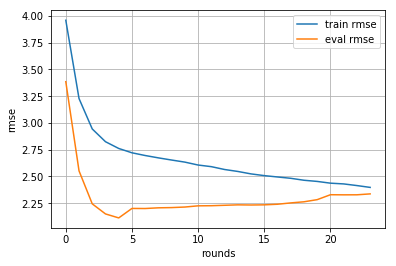

In [13]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

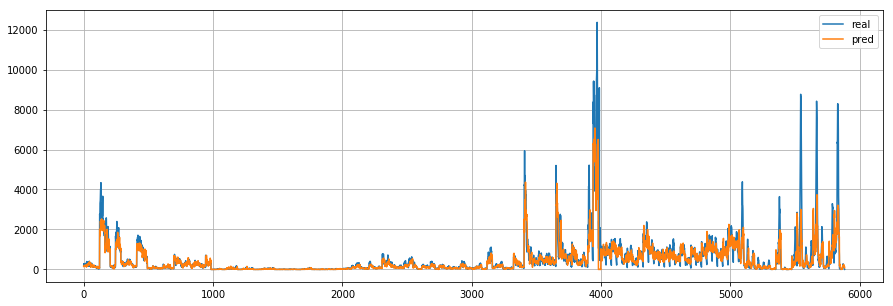

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Clicks'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

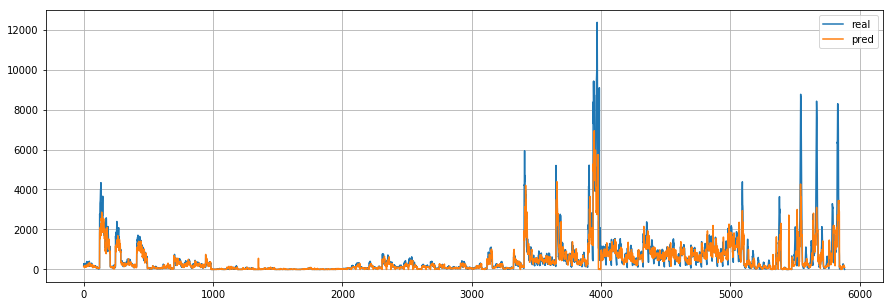

In [14]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Clicks'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

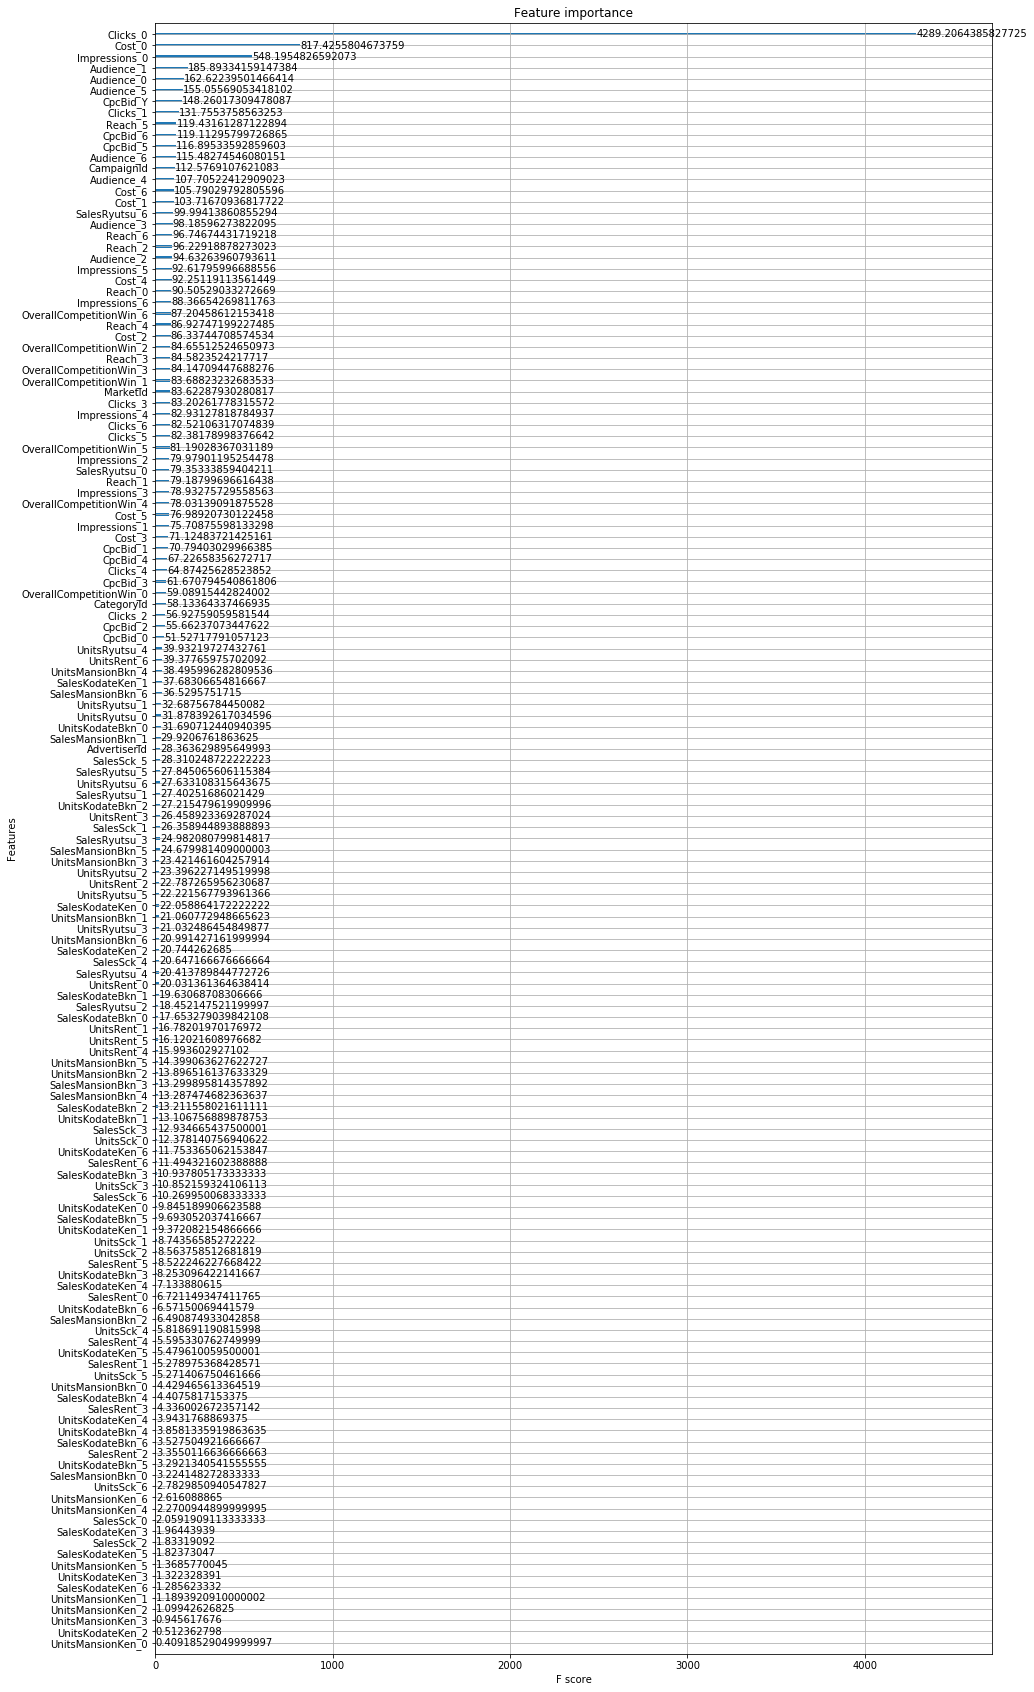

In [10]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Clicks_0',
 'Cost_0',
 'Impressions_0',
 'Audience_1',
 'Audience_0',
 'Audience_5',
 'CpcBid_Y',
 'Clicks_1',
 'Reach_5',
 'CpcBid_6',
 'CpcBid_5',
 'Audience_6',
 'CampaignId',
 'Audience_4',
 'Cost_6',
 'Cost_1',
 'SalesRyutsu_6',
 'Audience_3',
 'Reach_6',
 'Reach_2',
 'Audience_2',
 'Impressions_5',
 'Cost_4',
 'Reach_0',
 'Impressions_6',
 'OverallCompetitionWin_6',
 'Reach_4',
 'Cost_2',
 'OverallCompetitionWin_2',
 'Reach_3',
 'OverallCompetitionWin_3',
 'OverallCompetitionWin_1',
 'MarketId',
 'Clicks_3',
 'Impressions_4',
 'Clicks_6',
 'Clicks_5',
 'OverallCompetitionWin_5',
 'Impressions_2',
 'SalesRyutsu_0',
 'Reach_1',
 'Impressions_3',
 'OverallCompetitionWin_4',
 'Cost_5',
 'Impressions_1',
 'Cost_3',
 'CpcBid_1',
 'CpcBid_4',
 'Clicks_4',
 'CpcBid_3',
 'OverallCompetitionWin_0',
 'CategoryId',
 'Clicks_2',
 'CpcBid_2',
 'CpcBid_0',
 'UnitsRyutsu_4',
 'UnitsRent_6',
 'UnitsMansionBkn_4',
 'SalesKodateKen_1',
 'SalesMansionBkn_6',
 'UnitsRyutsu_1',
 'UnitsRyutsu_0',
 'U